### Import modules and packages. define functions

In [61]:
import numpy as np
import os
from nd2reader import ND2Reader
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_scalebar.scalebar import ScaleBar
import scipy.ndimage as ndi
from skimage.filters import rank 
from scipy.signal import butter, lfilter
import scipy.misc as misc
from skimage import exposure
from PIL import Image
import colorcet as cc
from scipy.misc import toimage
import matplotlib.colors as clr
import pandas as pd
import seaborn as sns
import pims
from scipy import stats

%matplotlib inline

def mean2(x):
    y = np.sum(x) / np.size(x);
    return y

def corr2(a,b):
    a = a - mean2(a)
    b = b - mean2(b)

    r = (a*b).sum() / np.sqrt((a*a).sum() * (b*b).sum());
    return r

plt.rcParams.update({'font.size': 22})


### Specify experiment directory, condtions and image details
#### Makes dictionary for Aggrecanr storage of results

In [62]:
expdir='/Users/taldankovich/Documents/LTPall/' #master folder

TNR_channel_no=1 
Aggrecan_channel_no=2 

results = {"filename":[],
           "Slice_id":[],
           "TNR colour - spots mask":[],
           "Aggrecan colour - spots mask":[],
           "exp condition":[],
           "TNR colour - Raw mean intensity":[],
           "Aggrecan colour - Raw mean intensity":[],
           "Mean correlation coefficient TNR/Aggrecan":[],
           "TNR colour - Mean intensity of spots":[], #based on spot segmentation mask
           "Aggrecan colour - Mean intensity of spots":[], #based on spot segmentation mask
           "TNR colour - Total no. of spots in FOV":[],
           "Aggrecan colour - Total no. of spots in FOV":[],
           "TNR colour - Mean spot area [nm]":[],
           "Aggrecan colour - Mean spot area [nm]":[],
           "Mean colour bias of a pixel (TNR=-1<x<1=Aggrecan)":[],
           "TNR colour - Mean intensity, masked by Aggrecan spots":[],
           "TNR colour - Mean intensity, outside of Aggrecan spots":[]}

path = os.path.dirname(expdir)  
outputFolder = os.path.dirname(expdir + "/new/")
filelist = []
for root, _, filenames in os.walk(path):
     for filename in filenames:
         filelist.append(os.path.join(root, filename))
        
for i in range(0,len(filelist)):
    if filelist[i].endswith(".tif") & ("60x" in str(filelist[i]))==True:
        results["filename"].append(filelist[i])
        results["exp condition"].append(filelist[i].split('/')[-2])
        head, sep, tail = filelist[i].partition('_60x_')
        head2, sep2, tail2 = head.partition('2018')
        results["Slice_id"].append(tail2)

### Find the spots: Segmentation masked made by adaptive thresholding followed by binary morphology
#### Play with sigma gauss and i (struct shape) to optimize first

/Users/taldankovich/anaconda/lib/python3.6/site-packages/tifffile/tifffile.py:2784: UserWarning: invalid page offset (2117224)
  warnings.warn("invalid page offset (%i)" % offset)


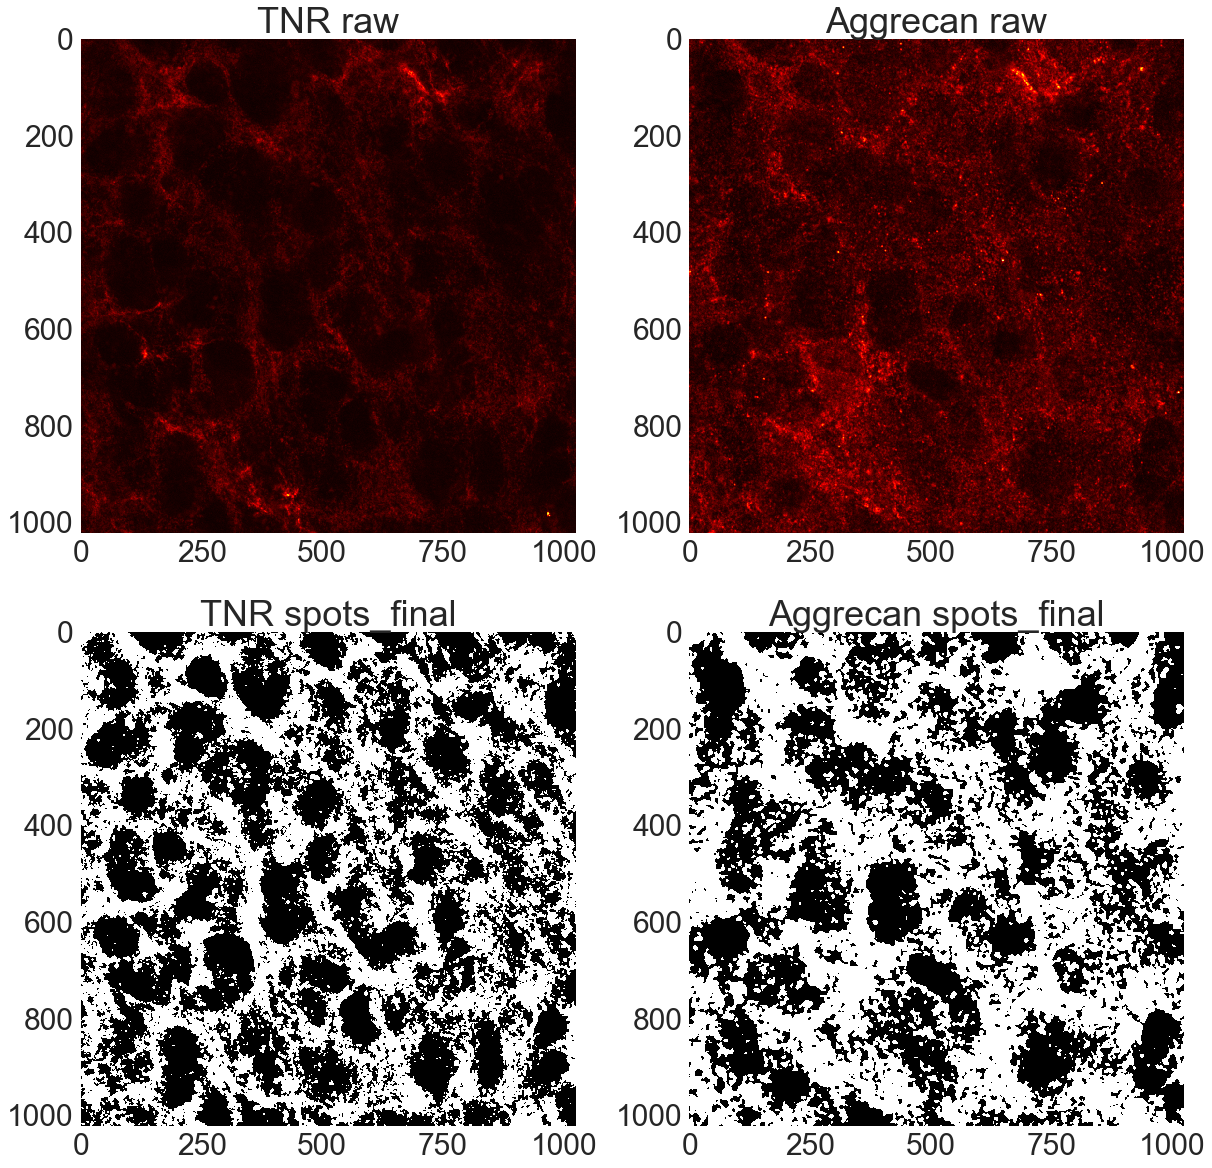

In [63]:
path=results['filename'][1]
im = pims.open(path)
TNR_image=im[TNR_channel_no-1]
Aggrecan_image=im[Aggrecan_channel_no-1]

sigmagauss_TNR=1 #Smoothing of TNR image
sigmagauss_Aggrecan=2 #Smoothing of Aggrecan image

TNR_smooth = ndi.filters.gaussian_filter(TNR_image,sigmagauss_TNR)
Aggrecan_smooth = ndi.filters.gaussian_filter(Aggrecan_image,sigmagauss_Aggrecan)

#adaptive thresholding - bg found by mean filter with SE
i_TNR=151 #for SE of TNR image
i_Aggrecan=301 #for SE of Aggrecan image

struct_TNR = (np.mgrid[:i_TNR,:i_TNR][0] - np.floor(i_TNR/2))**2 + (np.mgrid[:i_TNR,:i_TNR][1] - np.floor(i_TNR/2))**2 <= np.floor(i_TNR/2)**2
struct_Aggrecan = (np.mgrid[:i_Aggrecan,:i_Aggrecan][0] - np.floor(i_Aggrecan/2))**2 + (np.mgrid[:i_Aggrecan,:i_Aggrecan][1] - np.floor(i_Aggrecan/2))**2 <= np.floor(i_Aggrecan/2)**2
bg_TNR = rank.mean(TNR_smooth, selem=struct_TNR)
bg_Aggrecan = rank.mean(Aggrecan_smooth, selem=struct_Aggrecan)
TNR_spots = TNR_smooth >= bg_TNR
Aggrecan_spots = Aggrecan_smooth >= bg_Aggrecan

TNR_spots_final=TNR_spots
Aggrecan_spots_final=Aggrecan_spots

'''#improve with binary hole filling
TNR_spots_holes_filled = ndi.binary_fill_holes(np.logical_not(TNR_spots))
Aggrecan_spots_holes_filled = ndi.binary_fill_holes(np.logical_not(Aggrecan_spots))
#improve with binary closing
i2 = 3
struct2 = (np.mgrid[:i2,:i2][0] - np.floor(i2/2))**2 + (np.mgrid[:i2,:i2][1] - np.floor(i2/2))**2 <= np.floor(i2/2)**2
pad_size = i+2 #pad the spots image to avoid artifacts at the edges
padded_TNR_spots = np.pad(TNR_spots_holes_filled,pad_size,mode='reflect')
padded_Aggrecan_spots = np.pad(Aggrecan_spots_holes_filled,pad_size,mode='reflect')
TNR_spots_final = ndi.binary_closing(np.logical_not(padded_TNR_spots),structure=struct2)
Aggrecan_spots_final = ndi.binary_closing(np.logical_not(padded_Aggrecan_spots),structure=struct2)
#remove the padding from before
TNR_spots_final = TNR_spots_final[pad_size:-pad_size,pad_size:-pad_size]
Aggrecan_spots_final = Aggrecan_spots_final[pad_size:-pad_size,pad_size:-pad_size]'''
            
fig=plt.figure(figsize=(20,20))
fig.add_subplot(2,2,1)
plt.imshow(TNR_image,interpolation='none',cmap='hot')
plt.title('TNR raw')
ax=plt.gca()
ax.grid(color='none')
fig.add_subplot(2,2,2)
plt.imshow(Aggrecan_image,interpolation='none',cmap='hot')
plt.title('Aggrecan raw')
ax=plt.gca()
ax.grid(color='none')
fig.add_subplot(2,2,3)
plt.imshow(TNR_spots_final,cmap='gray')
plt.title('TNR spots_final')
ax=plt.gca()
ax.grid(color='none')
fig.add_subplot(2,2,4)
plt.imshow(Aggrecan_spots_final,cmap='gray')
plt.title('Aggrecan spots_final')
ax=plt.gca()
ax.grid(color='none')

#### After optimizing, run below to make segmentation masks for all images

In [64]:
print('Total number of images: ' + str(len(results['filename'])))

for i in range(0,len(results["filename"])): 
    print('Calculating image no ' + str(i))
    path=results['filename'][i]
    im = pims.open(path)
    TNR_image=im[TNR_channel_no-1]
    Aggrecan_image=im[Aggrecan_channel_no-1]

    TNR_smooth = ndi.filters.gaussian_filter(TNR_image,sigmagauss_TNR)
    Aggrecan_smooth = ndi.filters.gaussian_filter(Aggrecan_image,sigmagauss_Aggrecan)

    struct_TNR = (np.mgrid[:i_TNR,:i_TNR][0] - np.floor(i_TNR/2))**2 + (np.mgrid[:i_TNR,:i_TNR][1] - np.floor(i_TNR/2))**2 <= np.floor(i_TNR/2)**2
    struct_Aggrecan = (np.mgrid[:i_Aggrecan,:i_Aggrecan][0] - np.floor(i_Aggrecan/2))**2 + (np.mgrid[:i_Aggrecan,:i_Aggrecan][1] - np.floor(i_Aggrecan/2))**2 <= np.floor(i_Aggrecan/2)**2
    bg_TNR = rank.mean(TNR_smooth, selem=struct_TNR)
    bg_Aggrecan = rank.mean(Aggrecan_smooth, selem=struct_Aggrecan)
    TNR_spots = TNR_smooth >= bg_TNR
    Aggrecan_spots = Aggrecan_smooth >= bg_Aggrecan

    TNR_spots_final=TNR_spots
    Aggrecan_spots_final=Aggrecan_spots

    '''
    #improve with binary hole filling
    TNR_spots_holes_filled = ndi.binary_fill_holes(np.logical_not(TNR_spots))
    Aggrecan_spots_holes_filled = ndi.binary_fill_holes(np.logical_not(Aggrecan_spots))
    #improve with binary closing
    i2 = 3
    struct2 = (np.mgrid[:i2,:i2][0] - np.floor(i2/2))**2 + (np.mgrid[:i2,:i2][1] - np.floor(i2/2))**2 <= np.floor(i2/2)**2
    pad_size = i+2 #pad the spots image to avoid artifacts at the edges
    padded_TNR_spots = np.pad(TNR_spots_holes_filled,pad_size,mode='reflect')
    padded_Aggrecan_spots = np.pad(Aggrecan_spots_holes_filled,pad_size,mode='reflect')
    TNR_spots_final = ndi.binary_closing(np.logical_not(padded_TNR_spots),structure=struct2)
    Aggrecan_spots_final = ndi.binary_closing(np.logical_not(padded_Aggrecan_spots),structure=struct2)
    #remove the padding from before
    TNR_spots_final = TNR_spots_final[pad_size:-pad_size,pad_size:-pad_size]
    Aggrecan_spots_final = Aggrecan_spots_final[pad_size:-pad_size,pad_size:-pad_size]'''

    results["TNR colour - spots mask"].append(TNR_spots_final)
    results["Aggrecan colour - spots mask"].append(Aggrecan_spots_final)

Total number of images: 249
Calculating image no 0


/Users/taldankovich/anaconda/lib/python3.6/site-packages/tifffile/tifffile.py:2784: UserWarning: invalid page offset (2117224)
  warnings.warn("invalid page offset (%i)" % offset)


Calculating image no 1
Calculating image no 2
Calculating image no 3
Calculating image no 4
Calculating image no 5
Calculating image no 6
Calculating image no 7
Calculating image no 8
Calculating image no 9
Calculating image no 10
Calculating image no 11
Calculating image no 12
Calculating image no 13
Calculating image no 14
Calculating image no 15
Calculating image no 16
Calculating image no 17
Calculating image no 18
Calculating image no 19
Calculating image no 20
Calculating image no 21
Calculating image no 22
Calculating image no 23
Calculating image no 24
Calculating image no 25
Calculating image no 26
Calculating image no 27
Calculating image no 28
Calculating image no 29
Calculating image no 30
Calculating image no 31
Calculating image no 32
Calculating image no 33
Calculating image no 34
Calculating image no 35
Calculating image no 36
Calculating image no 37
Calculating image no 38
Calculating image no 39
Calculating image no 40
Calculating image no 41
Calculating image no 42
C

#### Verify the segmentation (look at a random subset of raw images and their masks)

/Users/taldankovich/anaconda/lib/python3.6/site-packages/tifffile/tifffile.py:2784: UserWarning: invalid page offset (2117224)
  warnings.warn("invalid page offset (%i)" % offset)


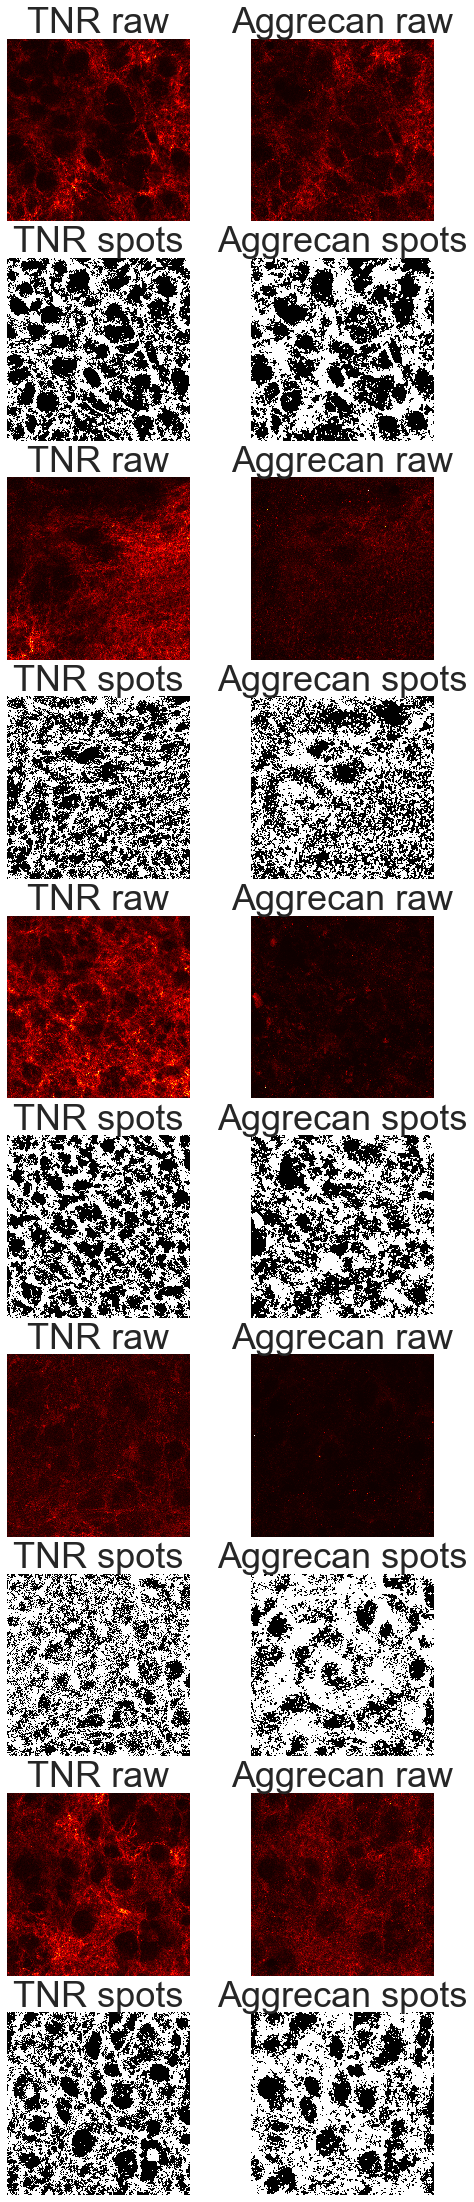

In [66]:
fig=plt.figure(figsize=(8,80))
figno=1
for im in range(0,5):
    randindex=np.random.randint(1,len(results["filename"]))
    path=results["filename"][randindex]
    image = pims.open(path)
    TNR_image=image[TNR_channel_no-1]
    Aggrecan_image=image[Aggrecan_channel_no-1]
    TNR_spots=results["TNR colour - spots mask"][randindex]
    Aggrecan_spots=results["Aggrecan colour - spots mask"][randindex]
    
    fig.add_subplot(20,2,figno)
    plt.imshow(TNR_image,interpolation='none',cmap='hot')
    plt.title('TNR raw')
    plt.ylabel(path)
    ax=plt.gca()
    ax.grid(color='none')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    fig.add_subplot(20,2,figno+1)
    plt.imshow(Aggrecan_image,interpolation='none',cmap='hot')
    plt.title('Aggrecan raw')
    ax=plt.gca()
    ax.grid(color='none')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    fig.add_subplot(20,2,figno+2)
    plt.imshow(TNR_spots,interpolation='none',cmap='gray')
    plt.title('TNR spots')
    ax=plt.gca()
    ax.grid(color='none')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    fig.add_subplot(20,2,figno+3)
    plt.imshow(Aggrecan_spots,interpolation='none',cmap='gray')
    plt.title('Aggrecan spots')
    ax=plt.gca()
    ax.grid(color='none')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    figno=figno+4

### Batch analyse images, after creating the segmentation masks

In [69]:
print('Total number of images: ' + str(len(results['filename'])))
for i in range(0,len(results["filename"])):    
    print('Calculating image no ' + str(i))
    path=results['filename'][i]
    im = pims.open(path)
    TNR_image=im[TNR_channel_no-1]
    Aggrecan_image=im[Aggrecan_channel_no-1]
    #read spots masks
    TNR_spots=results["TNR colour - spots mask"][i]
    Aggrecan_spots=results["Aggrecan colour - spots mask"][i]
    #label the spots
    spots_TNR_labels,_ = ndi.label(TNR_spots)
    spots_Aggrecan_labels,_ = ndi.label(Aggrecan_spots)
    #calcuAggrecan results
    TNR_spots_intensities=np.zeros((len(np.unique(spots_TNR_labels)),1))
    TNR_spots_areas=np.zeros((len(np.unique(spots_TNR_labels)),1))
    TNR_spots_intensities_maskedbyAggrecan=np.zeros((len(np.unique(spots_Aggrecan_labels)),1))
    Aggrecan_spots_intensities=np.zeros((len(np.unique(spots_Aggrecan_labels)),1))
    Aggrecan_spots_areas=np.zeros((len(np.unique(spots_Aggrecan_labels)),1))
    spots_Aggrecan_minus_TNR_int=np.zeros((len(np.unique(spots_TNR_labels)),1))

    for spotno in np.unique(spots_TNR_labels)[1:]:
        TNR_spots_mask = spots_TNR_labels==spotno
        TNR_spots_intensities[(spotno)]=np.mean(TNR_image[TNR_spots_mask])
        TNR_spots_areas[spotno]=np.sum(TNR_spots_mask)
        
        #calculation for Aggrecan minus TNR, based on TNR spots only
        a=Aggrecan_image[TNR_spots_mask]
        b=TNR_image[TNR_spots_mask]
        spots_Aggrecan_minus_TNR_int[spotno]=np.mean(np.divide([a-b],[a+b]))
        
    for spotnol in np.unique(spots_Aggrecan_labels)[1:]:
        Aggrecan_spots_mask= spots_Aggrecan_labels==spotnol
        Aggrecan_spots_intensities[spotnol]=np.mean(Aggrecan_image[Aggrecan_spots_mask])
        Aggrecan_spots_areas[spotnol]=np.sum(Aggrecan_spots_mask)
        TNR_spots_intensities_maskedbyAggrecan=np.mean(TNR_image[Aggrecan_spots_mask])
        TNR_spots_intensities_notAggrecan=np.mean(TNR_image[np.invert(Aggrecan_spots_mask)])

    #the following results are calcuAggrecand on the raw data

    #results based on spot segmentation    
    results["TNR colour - Mean intensity of spots"].append(np.mean(TNR_spots_intensities))
    results["Aggrecan colour - Mean intensity of spots"].append(np.mean(Aggrecan_spots_intensities))
    results["TNR colour - Total no. of spots in FOV"].append(len(TNR_spots_intensities))
    results["Aggrecan colour - Total no. of spots in FOV"].append(len(Aggrecan_spots_intensities))
    results["TNR colour - Mean spot area [nm]"].append(np.mean(TNR_spots_areas))
    results["Aggrecan colour - Mean spot area [nm]"].append(np.mean(Aggrecan_spots_areas))
    results["TNR colour - Mean intensity, masked by Aggrecan spots"].append(np.mean(TNR_spots_intensities_maskedbyAggrecan))
    results["TNR colour - Mean intensity, outside of Aggrecan spots"].append(np.mean(TNR_spots_intensities_notAggrecan))

    #global results
    results["TNR colour - Raw mean intensity"].append(np.mean(TNR_image))
    results["Aggrecan colour - Raw mean intensity"].append(np.mean(Aggrecan_image))
    results["Mean correlation coefficient TNR/Aggrecan"].append(corr2(TNR_image,Aggrecan_image))
    results["Mean colour bias of a pixel (TNR=-1<x<1=Aggrecan)"].append(np.mean(spots_Aggrecan_minus_TNR_int))

Total number of images: 249
Calculating image no 0


/Users/taldankovich/anaconda/lib/python3.6/site-packages/tifffile/tifffile.py:2784: UserWarning: invalid page offset (2117224)
  warnings.warn("invalid page offset (%i)" % offset)


Calculating image no 1
Calculating image no 2
Calculating image no 3
Calculating image no 4
Calculating image no 5
Calculating image no 6
Calculating image no 7


/Users/taldankovich/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:30: RuntimeWarning: divide by zero encountered in true_divide


Calculating image no 8
Calculating image no 9
Calculating image no 10
Calculating image no 11
Calculating image no 12
Calculating image no 13
Calculating image no 14
Calculating image no 15
Calculating image no 16
Calculating image no 17
Calculating image no 18
Calculating image no 19
Calculating image no 20
Calculating image no 21
Calculating image no 22
Calculating image no 23
Calculating image no 24
Calculating image no 25
Calculating image no 26
Calculating image no 27
Calculating image no 28
Calculating image no 29
Calculating image no 30
Calculating image no 31
Calculating image no 32
Calculating image no 33
Calculating image no 34
Calculating image no 35
Calculating image no 36
Calculating image no 37
Calculating image no 38
Calculating image no 39
Calculating image no 40
Calculating image no 41
Calculating image no 42
Calculating image no 43
Calculating image no 44
Calculating image no 45
Calculating image no 46
Calculating image no 47
Calculating image no 48
Calculating image 

### Make a clean figure of an experimental condition, with merged image and scalebar

107


/Users/taldankovich/anaconda/lib/python3.6/site-packages/tifffile/tifffile.py:2784: UserWarning: invalid page offset (2117224)
  warnings.warn("invalid page offset (%i)" % offset)


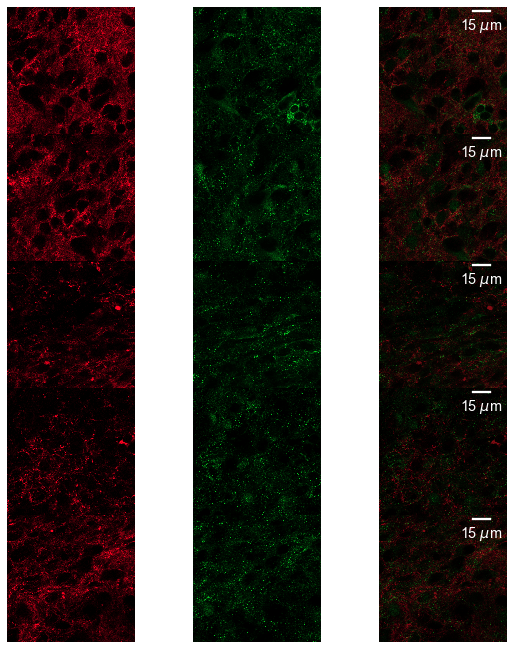

In [31]:
experimental_condition_to_displax='Ctrl' #'1 day' or '1 day + bic'

medfiltarray=[3,3] #play with med filter size

fig=plt.figure(figsize=(10,250))
no_of_ims_in_condition = sum( x == experimental_condition_to_display for x in results["exp condition"] )
print(no_of_ims_in_condition)
counter=1

for i in range(0,len(results["filename"])): 
    if (results["exp condition"][i]==experimental_condition_to_display and counter<15):
        path=results['filename'][i]
        im = pims.open(path)
        TNR_image=im[TNR_channel_no-1]
        Aggrecan_image=im[Aggrecan_channel_no-1]
       
        #some basic preprocessing: smoothing (noise reduction) with med filter, and contrast adjustment
        TNR_smoothed=ndi.filters.median_filter(TNR_image,medfiltarray)
        v_min1, v_max1 = np.percentile(TNR_smoothed, (0.2, 99.8))
        TNR_smoothed_adjusted=exposure.rescale_intensity(TNR_smoothed, in_range=(v_min1, v_max1))
        Aggrecan_smoothed=ndi.filters.median_filter(Aggrecan_image,medfiltarray)
        v_min2, v_max2 = np.percentile(Aggrecan_smoothed, (0.2, 99.8))
        Aggrecan_smoothed_adjusted=exposure.rescale_intensity(Aggrecan_smoothed, in_range=(v_min2, v_max2))

        #make TNR image red and Aggrecan image green
        greencmap = clr.LinearSegmentedColormap.from_list('customred', ['#000000','#06C420'], N=256)
        redcmap=clr.LinearSegmentedColormap.from_list('customred', ['#000000','#FD0120'], N=256)

        normTNR = TNR_smoothed_adjusted.astype(np.float32) # convert to float
        normTNR -= normTNR.min() # ensure the minimal value is 0.0
        normTNR /= normTNR.max() # maximum value in image is now 1.0
        normAggrecan = Aggrecan_smoothed_adjusted.astype(np.float32) # convert to float
        normAggrecan -= normAggrecan.min() # ensure the minimal value is 0.0
        normAggrecan /= normAggrecan.max() # maximum value in image is now 1.0

        Aggrecan_ingreen=greencmap(normAggrecan)
        TNR_inred=redcmap(normTNR)

        #make composite with a scalebar
        comp=Image.blend(toimage(TNR_inred),toimage(Aggrecan_ingreen),0.5)
        micronsperpixel=0.0962
        scalebar = ScaleBar(dx=micronsperpixel,units='um',color='white',length_fraction=0.16,box_color='none') # 1 pixel = 0.2 meter

        fig.add_subplot(no_of_ims_in_condition,3,counter)
        plt.imshow(TNR_inred,interpolation='none')
        plt.gca().set_xticklabels([])
        plt.gca().set_yticklabels([])
        plt.gca().set_aspect('equal')
        plt.gca().grid(color='none')

        fig.add_subplot(no_of_ims_in_condition,3,(counter+1))
        plt.imshow(Aggrecan_ingreen,interpolation='none')
        plt.gca().set_xticklabels([])
        plt.gca().set_yticklabels([])
        plt.gca().set_aspect('equal')
        plt.gca().grid(color='none')

        fig.add_subplot(no_of_ims_in_condition,3,(counter+2))
        plt.imshow(comp)
        plt.gca().add_artist(scalebar)
        plt.gca().set_xticklabels([])
        plt.gca().set_yticklabels([])
        plt.gca().set_aspect('equal')
        plt.gca().grid(color='none')

        counter=counter+3

plt.subplots_adjust(wspace=0, hspace=0)

### Plots

In [109]:
df=pd.DataFrame(results)

In [107]:
df=df.replace(to_replace='Untreated',value='01_Untreated')
df=df.replace(to_replace='LFS',value='02_LFS')
df=df.replace(to_replace='HFS',value='03_HFS')
df=df.replace(to_replace='LFS_AP5',value='04_LFS_AP5')
df=df.replace(to_replace='HFS_AP5',value='05_LFS_AP5')
df=df.replace(to_replace='LFS_CNQXAP5',value='06_LFS_CNQXAP5')
df=df.replace(to_replace='HFS_CNQXAP5',value='07_HFS_CNQXAP5')

/Users/taldankovich/anaconda/lib/python3.6/site-packages/pandas/core/missing.py:42: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask = arr == x


In [104]:
df.head()

,Aggrecan colour - Mean intensity of spots,Aggrecan colour - Mean spot area [nm],Aggrecan colour - Raw mean intensity,Aggrecan colour - Total no. of spots in FOV,Aggrecan colour - spots mask,Mean colour bias of a pixel (TNR=-1<x<1=Aggrecan),Mean correlation coefficient TNR/Aggrecan,Slice_id,TNR colour - Mean intensity of spots,"TNR colour - Mean intensity, masked by Aggrecan spots","TNR colour - Mean intensity, outside of Aggrecan spots",TNR colour - Mean spot area [nm],TNR colour - Raw mean intensity,TNR colour - Total no. of spots in FOV,TNR colour - spots mask,exp condition,filename
0,17.745669,802.813630,16.372581,719,"[[True, True, True, True, True, False, False, ...",2.141742,0.374677,0214_01_HFS,12.789032,35.500000,12.322231,243.269720,12.322585,1965,"[[False, False, False, False, False, False, Fa...",03_HFS,/Users/taldankovich/Documents/LTPall/HFS/20180...
1,17.527936,778.923077,16.286901,741,"[[True, True, True, True, True, True, True, Tr...",1.457569,0.496951,0214_01_HFS,11.638721,6.000000,11.009301,270.156180,11.009277,1780,"[[True, True, True, True, True, True, True, Tr...",03_HFS,/Users/taldankovich/Documents/LTPall/HFS/20180...
2,12.037554,1504.560825,11.473545,485,"[[True, True, True, True, False, False, False,...",2.663491,0.065844,0214_01_HFS,9.738964,8.770270,9.653118,252.914474,9.652993,2128,"[[False, False, False, False, False, False, Fa...",03_HFS,/Users/taldankovich/Documents/LTPall/HFS/20180...
3,12.471378,1285.059567,11.843154,554,"[[False, False, False, False, False, False, Fa...",3.019716,0.049361,0214_01_HFS,10.152450,9.000000,9.970793,229.873442,9.970790,2086,"[[False, False, False, False, False, False, Tr...",03_HFS,/Users/taldankovich/Documents/LTPall/HFS/20180...
4,12.170875,1412.903543,11.802138,508,"[[False, False, False, False, False, False, Fa...",3.817898,0.093565,0214_01_HFS,10.917047,6.066667,10.544356,235.747982,10.544291,2230,"[[False, False, False, False, False, False, Fa...",03_HFS,/Users/taldankovich/Documents/LTPall/HFS/20180...


In [72]:
df.to_json(path_or_buf=expdir+'results.json')

OSError: [Errno 28] No space left on device: '/Users/taldankovich/Documents/LTPall/results.json'

In [ ]:
df=pd.read_json(path_or_buf=expdir+'results.json')

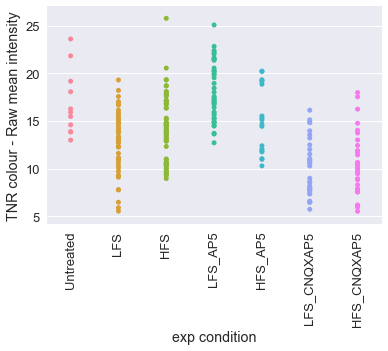

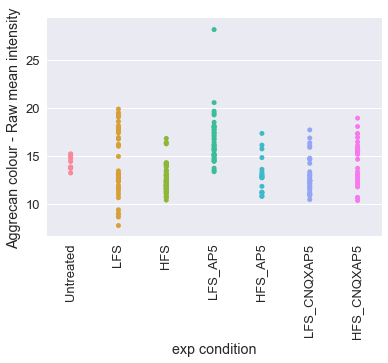

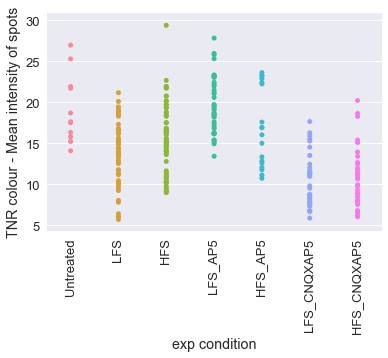

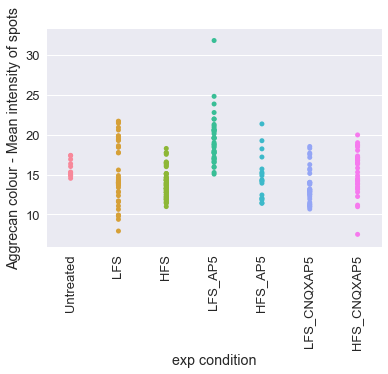

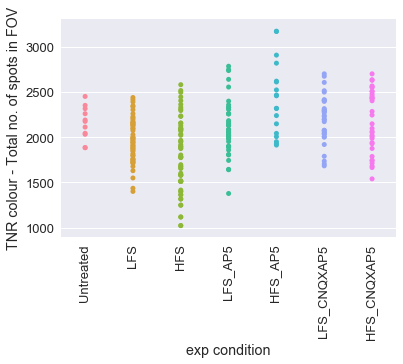

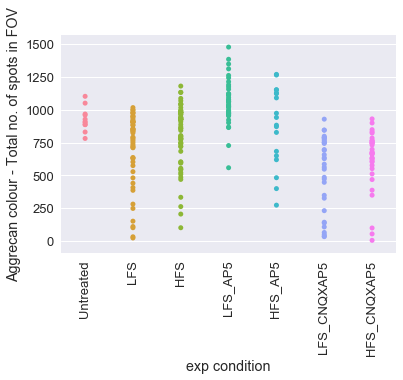

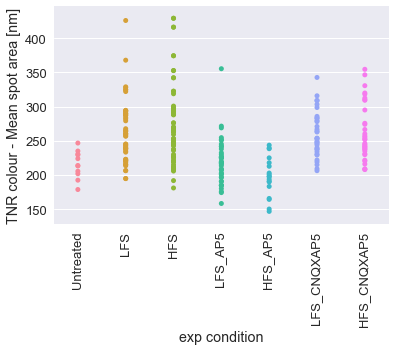

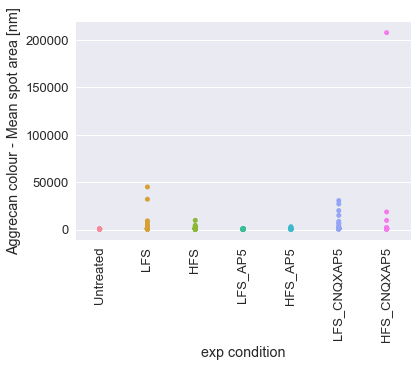

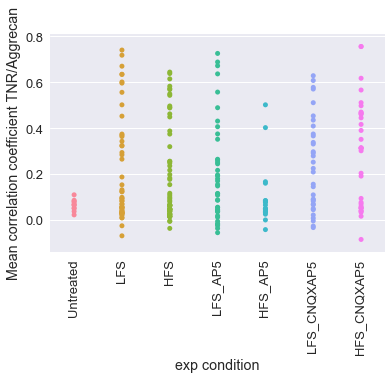

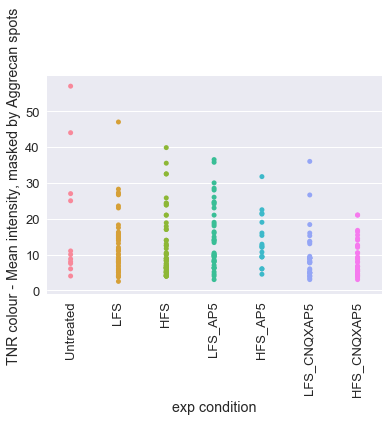

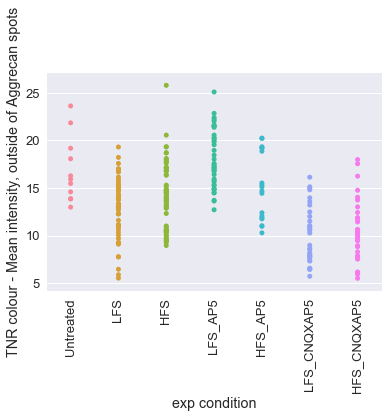

In [124]:
sns.set(font_scale=1.3)


fig1=plt.figure()
d=sns.stripplot(y ="TNR colour - Raw mean intensity", x="exp condition",data=df,#ci='sd',
                 order=["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"])
#d=sns.swarmplot(y ="TNR colour - Raw mean intensity", x="exp condition",data=df,color='black')
d.set_xticklabels(labels = ["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"],rotation=90)
fig1.savefig('plot1.png',bbox_inches='tight')

fig2=plt.figure()
d=sns.stripplot(y ='Aggrecan colour - Raw mean intensity', x='exp condition',data=df, #ci='sd',
                 order=["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"])
#d=sns.swarmplot(y ="Aggrecan colour - Raw mean intensity", x="exp condition",data=df,color='black')
d.set_xticklabels(labels = ["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"],rotation=90)
fig2.savefig('plot2.png',bbox_inches='tight')

fig3=plt.figure()
d=sns.stripplot(y ='TNR colour - Mean intensity of spots', x='exp condition',data=df, #ci='sd',
                 order=["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"])
#d=sns.swarmplot(y ="TNR colour - Mean intensity of spots", x="exp condition",data=df,color='black')
d.set_xticklabels(labels = ["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"],rotation=90)
fig3.savefig('plot3.png',bbox_inches='tight')

fig4=plt.figure()
d=sns.stripplot(y ='Aggrecan colour - Mean intensity of spots', x='exp condition',data=df, #ci='sd',
                 order=["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"])
#d=sns.swarmplot(y ="Aggrecan colour - Mean intensity of spots", x="exp condition",data=df,color='black')
d.set_xticklabels(labels = ["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"],rotation=90)
fig4.savefig('plot4.png',bbox_inches='tight')

fig5=plt.figure()
d=sns.stripplot(y ='TNR colour - Total no. of spots in FOV', x='exp condition',data=df, #ci='sd',
                 order=["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"])
#d=sns.swarmplot(y ="TNR colour - Total no. of spots in FOV", x="exp condition",data=df,color='black')
d.set_xticklabels(labels = ["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"],rotation=90)
fig5.savefig('plot5.png',bbox_inches='tight')

fig6=plt.figure()
d=sns.stripplot(y ='Aggrecan colour - Total no. of spots in FOV', x='exp condition',data=df, #ci='sd',
                 order=["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"])
#d=sns.swarmplot(y ="Aggrecan colour - Total no. of spots in FOV", x="exp condition",data=df,color='black')
d.set_xticklabels(labels = ["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"],rotation=90)
fig6.savefig('plot6.png',bbox_inches='tight')

fig7=plt.figure()
d=sns.stripplot(y ='TNR colour - Mean spot area [nm]', x='exp condition',data=df, #ci='sd',
                 order=["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"])
#d=sns.swarmplot(y ="TNR colour - Mean spot area [nm]", x="exp condition",data=df,color='black')
d.set_xticklabels(labels = ["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"],rotation=90)
fig7.savefig('plot7.png',bbox_inches='tight')

fig8=plt.figure()
d=sns.stripplot(y ='Aggrecan colour - Mean spot area [nm]', x='exp condition',data=df, #ci='sd',
                 order=["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"])
#d=sns.swarmplot(y ="Aggrecan colour - Mean spot area [nm]", x="exp condition",data=df,color='black')
d.set_xticklabels(labels = ["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"],rotation=90)
fig8.savefig('plot8.png',bbox_inches='tight')

fig9=plt.figure()
d=sns.stripplot(y ='Mean correlation coefficient TNR/Aggrecan', x='exp condition',data=df, #ci='sd',
                 order=["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"])
#d=sns.swarmplot(y ="Mean correlation coefficient TNR/Aggrecan", x="exp condition",data=df,color='black')
d.set_xticklabels(labels = ["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"],rotation=90)
fig9.savefig('plot9.png',bbox_inches='tight')

fig10=plt.figure()
d=sns.stripplot(y ='TNR colour - Mean intensity, masked by Aggrecan spots', x='exp condition',data=df, #ci='sd',
                 order=["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"])
#d=sns.swarmplot(y ="TNR colour - Mean intensity, masked by Aggrecan spots", x="exp condition",data=df,color='black')
d.set_xticklabels(labels = ["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"],rotation=90)
fig10.savefig('plot10.png',bbox_inches='tight')

fig11=plt.figure()
d=sns.stripplot(y ='TNR colour - Mean intensity, outside of Aggrecan spots', x='exp condition',data=df, #ci='sd',
                 order=["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"])
#d=sns.swarmplot(y ="TNR colour - Mean intensity, outside of Aggrecan spots", x="exp condition",data=df,color='black')
d.set_xticklabels(labels = ["Untreated","LFS","HFS","LFS_AP5","HFS_AP5","LFS_CNQXAP5","HFS_CNQXAP5"],rotation=90)
fig11.savefig('plot11.png',bbox_inches='tight')






3.301194282268938e-06


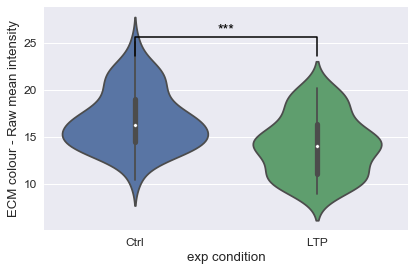

1.8068898617350772e-12


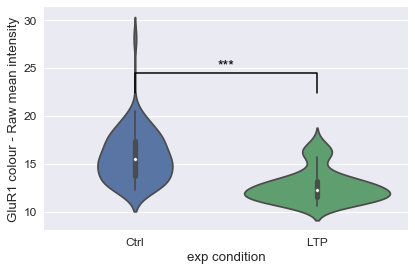

1.859621858672529e-05


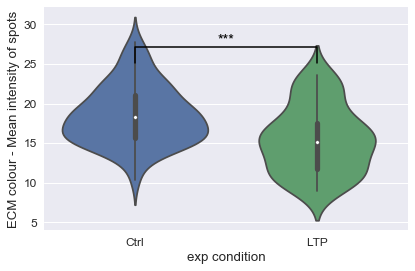

1.696644658893304e-13


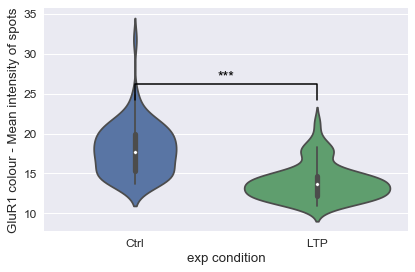

0.48507784719925795


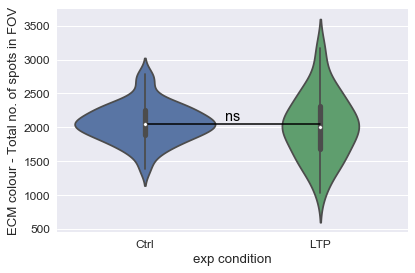

2.6592960644879673e-08


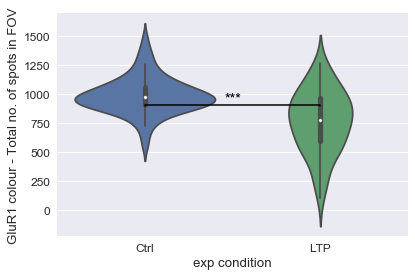

0.061398625295287224


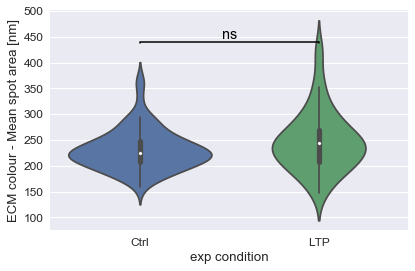

0.0002462449213179797


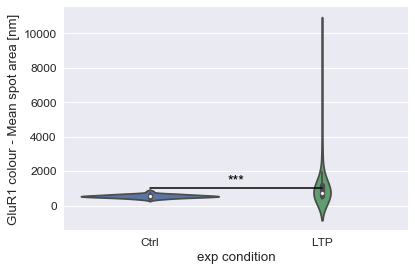

0.24268496484026505


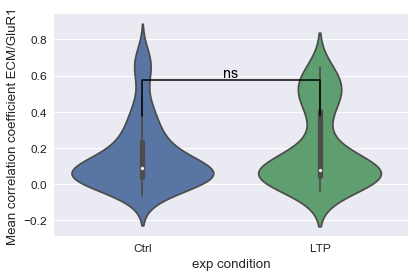

0.022428703635037666


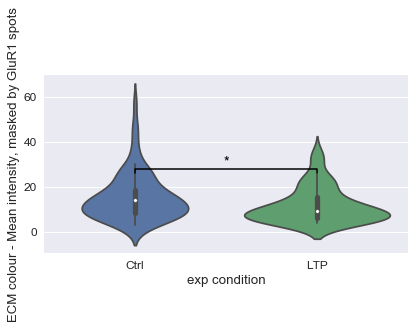

3.301284871156897e-06


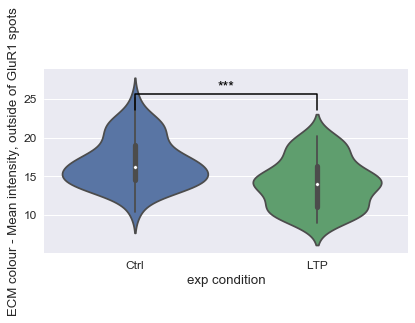

In [47]:
#statistics with scipy, plots with seaborn
sns.set(font_scale=1.2)

#raw mean intensity TNR
TNRrawint_Ctrl = df[df['exp condition'] == 'Ctrl']['TNR colour - Raw mean intensity']
TNRrawint_LTP = df[df['exp condition'] == 'LTP']['TNR colour - Raw mean intensity']
[stat,pval]=stats.ttest_ind(TNRrawint_Ctrl, TNRrawint_LTP)
print(pval)
sns.factorplot(kind='bar', x='TNR colour - Raw mean intensity', y ='exp condition',data=df, size=4, aspect=1.5, legend_out=False) 
x1, x2 = 0, 1   # columns 'Ctrl' and 'LTP'
y, h, col = df['TNR colour - Raw mean intensity'].mean() + 8, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
plt.show()

#raw mean intensity Aggrecan
Aggrecanrawint_Ctrl = df[df['exp condition'] == 'Ctrl']['Aggrecan colour - Raw mean intensity']
Aggrecanrawint_LTP = df[df['exp condition'] == 'LTP']['Aggrecan colour - Raw mean intensity']
[stat,pval]=stats.ttest_ind(Aggrecanrawint_Ctrl, Aggrecanrawint_LTP)
print(pval)
sns.factorplot(kind='bar', x='Aggrecan colour - Raw mean intensity', y ='exp condition',data=df, size=4, aspect=1.5, legend_out=False) 
x1, x2 = 0, 1   # columns 'Ctrl' and 'LTP'
y, h, col = df['Aggrecan colour - Raw mean intensity'].mean() + 8, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
plt.show()

#raw mean intensity TNR spots
TNRspotint_Ctrl = df[df['exp condition'] == 'Ctrl']['TNR colour - Mean intensity of spots']
TNRspotint_LTP = df[df['exp condition'] == 'LTP']['TNR colour - Mean intensity of spots']
[stat,pval]=stats.ttest_ind(TNRspotint_Ctrl, TNRspotint_LTP)
print(pval)
sns.factorplot(kind='bar', x='TNR colour - Mean intensity of spots', y ='exp condition',data=df, size=4, aspect=1.5, legend_out=False) 
x1, x2 = 0, 1   # columns 'Ctrl' and 'LTP'
y, h, col = df['TNR colour - Mean intensity of spots'].mean() + 8, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
plt.show()

#raw mean intensity Aggrecan spots
Aggrecanspotint_Ctrl = df[df['exp condition'] == 'Ctrl']['Aggrecan colour - Mean intensity of spots']
Aggrecanspotint_LTP = df[df['exp condition'] == 'LTP']['Aggrecan colour - Mean intensity of spots']
[stat,pval]=stats.ttest_ind(Aggrecanspotint_Ctrl, Aggrecanspotint_LTP)
print(pval)
sns.factorplot(kind='bar', x='Aggrecan colour - Mean intensity of spots', y ='exp condition',data=df, size=4, aspect=1.5, legend_out=False) 
x1, x2 = 0, 1   # columns 'Ctrl' and 'LTP'
y, h, col = df['Aggrecan colour - Mean intensity of spots'].mean() + 8, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
plt.show()

#NO of TNR spots in FOV
TNRspotno_Ctrl = df[df['exp condition'] == 'Ctrl']['TNR colour - Total no. of spots in FOV']
TNRspotno_LTP = df[df['exp condition'] == 'LTP']['TNR colour - Total no. of spots in FOV']
[stat,pval]=stats.ttest_ind(TNRspotno_Ctrl, TNRspotno_LTP)
print(pval)
sns.factorplot(kind='bar', x='TNR colour - Total no. of spots in FOV', y ='exp condition',data=df, size=4, aspect=1.5, legend_out=False) 
x1, x2 = 0, 1   # columns 'Ctrl' and 'LTP'
y, h, col = df['TNR colour - Total no. of spots in FOV'].mean() + 8, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
plt.show()

#NO of Aggrecan spots in FOV
Aggrecanspotno_Ctrl = df[df['exp condition'] == 'Ctrl']['Aggrecan colour - Total no. of spots in FOV']
Aggrecanspotno_LTP = df[df['exp condition'] == 'LTP']['Aggrecan colour - Total no. of spots in FOV']
[stat,pval]=stats.ttest_ind(Aggrecanspotno_Ctrl, Aggrecanspotno_LTP)
print(pval)
sns.factorplot(kind='bar', x='Aggrecan colour - Total no. of spots in FOV', y ='exp condition',data=df, size=4, aspect=1.5, legend_out=False) 
x1, x2 = 0, 1   # columns 'Ctrl' and 'LTP'
y, h, col = df['Aggrecan colour - Total no. of spots in FOV'].mean() + 8, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
plt.show()

#Spot Area of TNR 
TNRspotarea_Ctrl = df[df['exp condition'] == 'Ctrl']['TNR colour - Mean spot area [nm]']
TNRspotarea_LTP = df[df['exp condition'] == 'LTP']['TNR colour - Mean spot area [nm]']
[stat,pval]=stats.ttest_ind(TNRspotarea_Ctrl, TNRspotarea_LTP)
print(pval)
sns.factorplot(kind='bar', x='TNR colour - Mean spot area [nm]', y ='exp condition',data=df, size=4, aspect=1.5, legend_out=False) 
x1, x2 = 0, 1   # columns 'Ctrl' and 'LTP'
y, h, col = df['TNR colour - Mean spot area [nm]'].mean() + 200, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
plt.show()

#Aggrecan spot area
Aggrecanspotarea_Ctrl = df[df['exp condition'] == 'Ctrl']['Aggrecan colour - Mean spot area [nm]']
Aggrecanspotarea_LTP = df[df['exp condition'] == 'LTP']['Aggrecan colour - Mean spot area [nm]']
[stat,pval]=stats.ttest_ind(Aggrecanspotarea_Ctrl, Aggrecanspotarea_LTP)
print(pval)
sns.factorplot(kind='bar', x='Aggrecan colour - Mean spot area [nm]', y ='exp condition',data=df, size=4, aspect=1.5, legend_out=False) 
x1, x2 = 0, 1   # columns 'Ctrl' and 'LTP'
y, h, col = df['Aggrecan colour - Mean spot area [nm]'].mean() + 200, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
plt.show()

#Corrcoeff TNR Aggrecan
Corrcoeff_Ctrl = df[df['exp condition'] == 'Ctrl']['Mean correlation coefficient TNR/Aggrecan']
Corrcoeff_LTP = df[df['exp condition'] == 'LTP']['Mean correlation coefficient TNR/Aggrecan']
[stat,pval]=stats.ttest_ind(Corrcoeff_Ctrl, Corrcoeff_LTP)
print(pval)
sns.factorplot(kind='bar', x='Mean correlation coefficient TNR/Aggrecan', y ='exp condition',data=df, size=4, aspect=1.5, legend_out=False) 
x1, x2 = 0, 1   # columns 'Ctrl' and 'LTP'
y, h, col = df['Mean correlation coefficient TNR/Aggrecan'].mean()+0.2 , 0.2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
plt.show()

#TNR intensity, masked by Aggrecan
TNRsynapsesint_Ctrl = df[df['exp condition'] == 'Ctrl']['TNR colour - Mean intensity, masked by Aggrecan spots']
TNRsynapsesint_LTP = df[df['exp condition'] == 'LTP']['TNR colour - Mean intensity, masked by Aggrecan spots']
[stat,pval]=stats.ttest_ind(TNRsynapsesint_Ctrl, TNRsynapsesint_LTP)
print(pval)
sns.factorplot(kind='bar', x='TNR colour - Mean intensity, masked by Aggrecan spots', y ='exp condition',data=df, size=4, aspect=1.5, legend_out=False) 
x1, x2 = 0, 1   # columns 'Ctrl' and 'LTP'
y, h, col = df['TNR colour - Mean intensity, masked by Aggrecan spots'].mean() + 12, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
plt.show()

#TNR intensity, not masked by Aggrecan
TNRnotsynapsesint_Ctrl = df[df['exp condition'] == 'Ctrl']['TNR colour - Mean intensity, outside of Aggrecan spots']
TNRnotsynapsesint_LTP = df[df['exp condition'] == 'LTP']['TNR colour - Mean intensity, outside of Aggrecan spots']
[stat,pval]=stats.ttest_ind(TNRnotsynapsesint_Ctrl, TNRnotsynapsesint_LTP)
print(pval)
sns.factorplot(kind='bar', x='TNR colour - Mean intensity, outside of Aggrecan spots', y ='exp condition',data=df, size=4, aspect=1.5, legend_out=False) 
x1, x2 = 0, 1   # columns 'Ctrl' and 'LTP'
y, h, col = df['TNR colour - Mean intensity, outside of Aggrecan spots'].mean() + 8, 2, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col)
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
else:
    plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col)
plt.show()


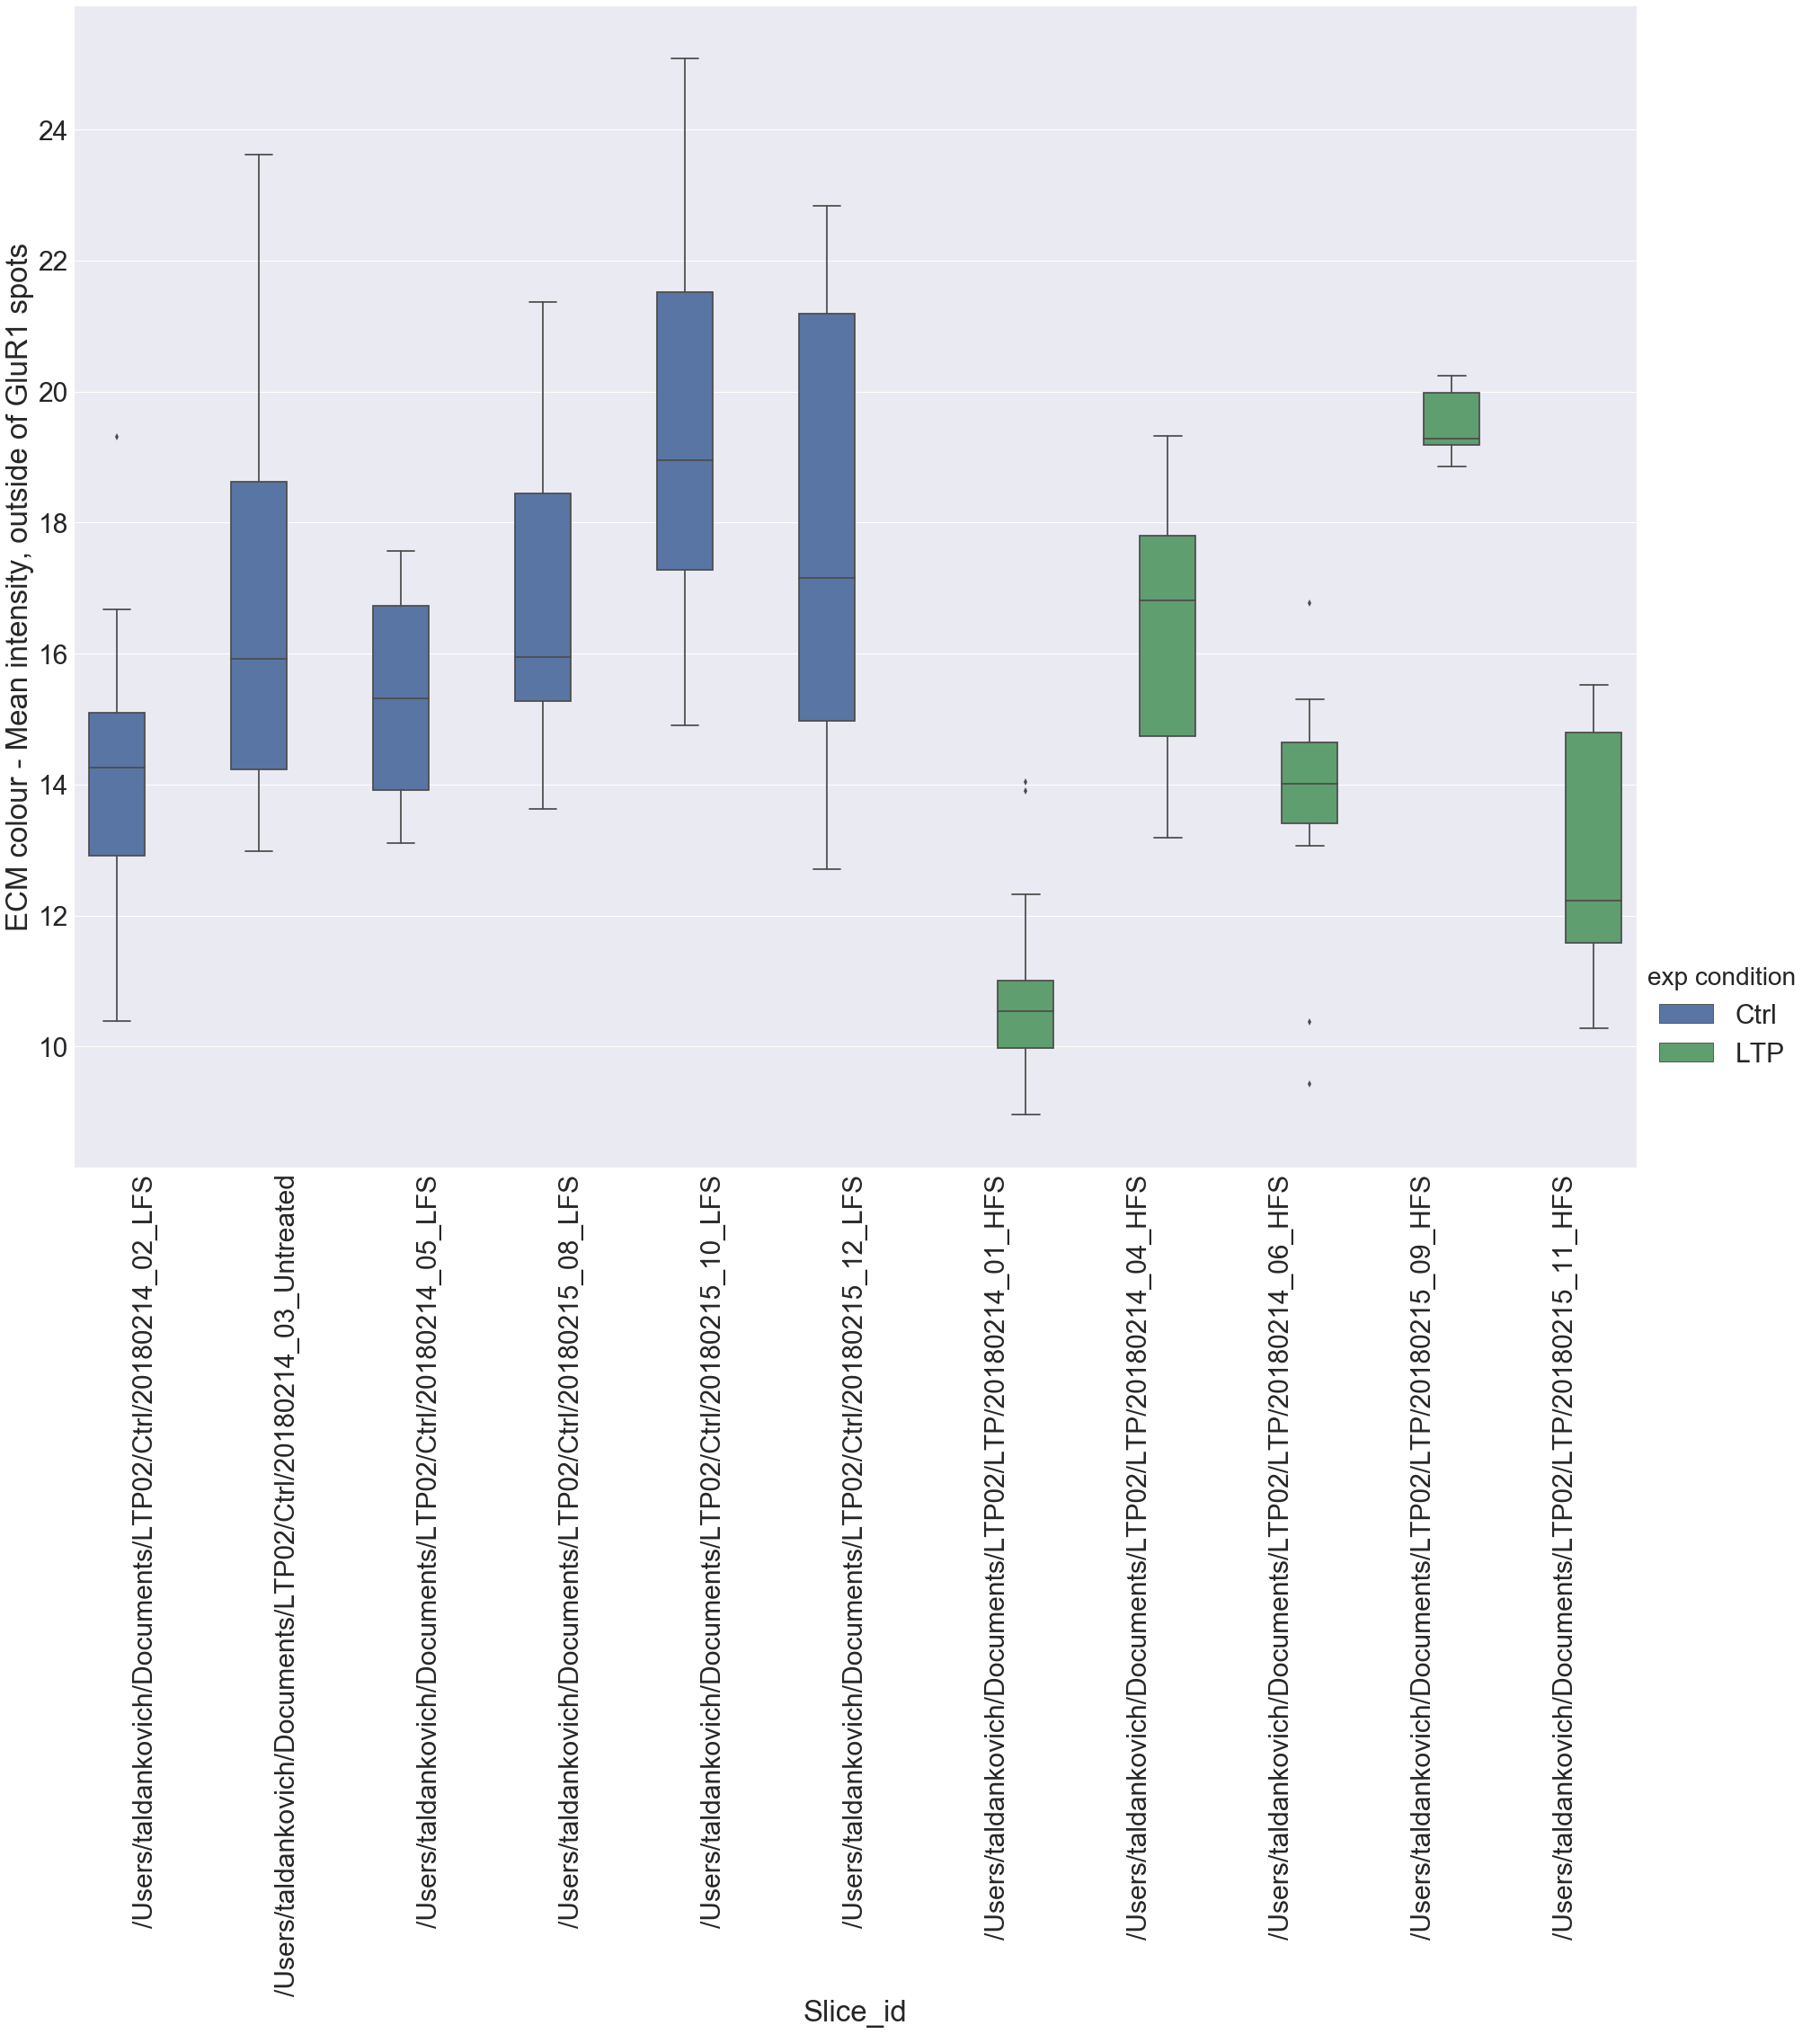

In [48]:
sns.set(font_scale=3)

g=sns.factorplot(kind='box', x='TNR colour - Mean intensity, outside of Aggrecan spots', y ='Slice_id',hue='exp condition',data=df, size=20, aspect=1.5, legend_out=True) 
#g.set(font_scale=1)
g.set_xticklabels(rotation=90)
